# Projet 4 : Anticipez les besoins en consommation de bâtiments
## NB 3 : Prédiction des émissions de gas à effet de serre en tonnes de C02
 
### Sommaire
 
 
**Partie 1 : Importation du jeu de données**
 - <a href="#C1"> 1. Importation des données</a>
 
**Partie 2 : Régressions linéaires** 
 - <a href="#C2">2. Régressions linéaires  </a>
     - <a href="#C20">2.0 Baseline : DummyRegressor </a>
     - <a href="#C21">2.1 LinearRegression OLS </a>
     - <a href="#C22">2.2 Ridge regression </a>
     - <a href="#C23">2.3 Lasso regression </a>
     - <a href="#C24">2.4 ElasticNet regression </a>
             
**Partie 3 : Régressions non linéaires** 
 - <a href="#C3"> 3. Régression non linéaires  </a>
     - <a href="#C31"> 3.1 SVR / LinearSVR </a>
     - <a href="#C32"> 3.2 DecisionTreeRegressor </a>
     - <a href="#C33"> 3.3 RandomForest </a>
     - <a href="#C34"> 3.4 XGBOOST </a>


In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <a name="C1"> 1. Importation </a>

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_
import shap


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
file = ['df_set0.csv','df_set3.csv']

#choix du dataset 0 ou 1 (set 1 ou set 3)
df= pd.read_csv(file[0],  
                dtype={'ID' : 'object',      
                      })
df = df.drop(columns = ['Unnamed: 0','INT_CONSOMMATION_ENERG_SITE','CONSOMMATION_ENERG_SITE', 
                        'STEAM(kBtu)', 'SUPERFICIE_PARKING','Electricity(kBtu)', 
                        'NaturalGas(kBtu)', 'ÉMISSIONS_TOTALES', 'NAN_ENERGY',  
                        'FONCTION_2' ,  'FONCTION_3', 
                        'LargestPropertyUseTypeGFA',
                        'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'     
                      ])


In [5]:
import sklearn
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler,  StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
from category_encoders import *
set_config(display="diagram")

In [6]:
cat_features = df.dtypes[df.dtypes == 'object'].index.tolist()
numeric_transformer =  MinMaxScaler()
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()
num_features.remove('INTENSITÉ_ÉMISSIONS') 

set_ = 1
tar_name = 'GHGEmissionsIntensity'

if set_ ==1 : 
  #Implémentaion SET1
  ls = ['ID']
  cat_features = [i for i in cat_features if i not in ls]
  target_transformer = OneHotEncoder(use_cat_names= True)
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer, cat_features),
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')
elif set_==2:
  #Implémentaion SET2
  ls = ['ID', 'FONCTION_1','FONCTION_2', 'FONCTION_3']
  cat_features = [i for i in cat_features if i not in ls]
  cat_features_fonction = ['FONCTION_1','FONCTION_2', 'FONCTION_3']
  target_transformer0 = OneHotEncoder(use_cat_names= True)
  target_transformer1 = TargetEncoder()
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer0, cat_features),
    ('target', target_transformer1, cat_features_fonction),
   ('numeric', numeric_transformer, num_features)], remainder='passthrough')
elif set_ == 3:
  #Implémentaion SET3
  ls = ['ID', 'FONCTION_1_BAR & RESTAURANT',
       'FONCTION_1_CONVENTION CENTERS', 'FONCTION_1_DATA CENTER',
       'FONCTION_1_GYM/LIFESTYLE', 'FONCTION_1_HOSPITAL', 'FONCTION_1_HOTEL',
       'FONCTION_1_INDUSTRIAL PLANTS', 'FONCTION_1_LABORATORY',
       'FONCTION_1_MALL', 'FONCTION_1_OFFICE', 'FONCTION_1_OTHER',
       'FONCTION_1_PARKING', 'FONCTION_1_PUBLIC SERVICES',
       'FONCTION_1_RECREATION & CULTURE', 'FONCTION_1_REFRIGERATED WAREHOUSE',
       'FONCTION_1_RETAIL STORE', 'FONCTION_1_SCHOOL', 'FONCTION_1_UNIVERSITY',
       'FONCTION_1_WAREHOUSE', 'FONCTION_1_WORSHIP FACILITY']
  cat_features = [i for i in cat_features if i not in ls]
  target_transformer0 = OneHotEncoder(use_cat_names= True)
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer0, cat_features),
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')





In [7]:
## Séparation des datas
#df['ID_store'] = df['ID']
df['ID'] = 1.
df = df.rename(columns = {'ID':'Intercept'})
X = df.drop('INTENSITÉ_ÉMISSIONS', axis = 1)
y = df['INTENSITÉ_ÉMISSIONS']

xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                 train_size=0.8, 
                                                                 random_state = 1)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(xtrain.shape[0],
                                                            xtest.shape[0]))

Entrainement: 1167 lignes,
Test: 292 lignes.



In [8]:
xtrain

,Intercept,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
757,1.0,NONRESIDENTIAL,RETAIL STORE,DOWNTOWN,47.61230,-122.34395,1920,1.0,2,26400,36.000000,0.000000,0.0,0.773857,0.226143
598,1.0,NONRESIDENTIAL,OFFICE,DOWNTOWN,47.60237,-122.33365,1902,1.0,3,23563,67.000000,0.000000,0.0,1.000000,0.000000
215,1.0,NONRESIDENTIAL,RETAIL STORE,DOWNTOWN,47.61159,-122.33601,1914,1.0,4,79957,25.000000,0.000000,0.0,1.000000,0.000000
135,1.0,NONRESIDENTIAL,OTHER,MAGNOLIA QUEEN ANNE,47.63965,-122.37830,1973,1.0,1,76086,94.020419,0.000000,0.0,0.478450,0.521550
372,1.0,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.56549,-122.33221,1957,1.0,1,50832,63.000000,0.000000,0.0,0.240684,0.759316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1.0,NONRESIDENTIAL,OFFICE,LAKE UNION,47.65570,-122.34682,1958,1.0,2,21436,95.000000,0.000000,0.0,1.000000,0.000000
905,1.0,NONRESIDENTIAL,OFFICE,BALLARD,47.66431,-122.37988,1966,1.0,1,22282,93.000000,0.000000,0.0,0.528202,0.471798
1096,1.0,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,33320,51.438740,0.000000,0.0,0.551135,0.448865
235,1.0,NONRESIDENTIAL,OFFICE,DOWNTOWN,47.61170,-122.34778,1998,1.0,11,374405,72.000000,49.351905,0.0,1.000000,0.000000


In [9]:
xtrain.describe()

,Intercept,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
count,1167.0,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000
mean,1.0,47.615212,-122.334255,1961.495287,1.132819,4.297344,1.185120e+05,62.387525,6.979368,0.021942,0.707685,0.270373
std,0.0,0.046335,0.022634,32.487677,0.905677,6.559388,2.058876e+05,27.138317,14.835695,0.092154,0.263215,0.264211
min,1.0,47.509590,-122.411820,1900.000000,1.000000,0.000000,1.276900e+04,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,47.586660,-122.343065,1930.000000,1.000000,1.000000,2.920000e+04,44.228620,0.000000,0.000000,0.494521,0.000000
50%,1.0,47.612107,-122.333200,1965.000000,1.000000,2.000000,4.925200e+04,67.000000,0.000000,0.000000,0.724544,0.222649
75%,1.0,47.644415,-122.323775,1988.000000,1.000000,4.000000,1.091820e+05,86.000000,0.000000,0.000000,1.000000,0.486443
max,1.0,47.733870,-122.262350,2015.000000,14.000000,76.000000,2.200000e+06,100.000000,79.816743,0.653410,1.000000,1.000000


In [10]:
xtest

,Intercept,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
1108,1.0,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000
111,1.0,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884
1273,1.0,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513
1147,1.0,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113
368,1.0,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,1.0,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473
1400,1.0,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356
131,1.0,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279
1142,1.0,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519


In [11]:
xtest.describe()

,Intercept,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
count,292.0,292.000000,292.000000,292.000000,292.000000,292.000000,2.920000e+02,292.000000,292.000000,292.000000,292.000000,292.000000
mean,1.0,47.616535,-122.332724,1961.071918,1.198630,3.712329,1.027405e+05,62.059501,4.646775,0.025239,0.699057,0.275704
std,0.0,0.050144,0.025274,33.057458,2.012401,5.617791,1.627120e+05,27.348473,11.689028,0.101275,0.260263,0.262619
min,1.0,47.510180,-122.407650,1900.000000,1.000000,0.000000,2.000000e+04,1.000000,0.000000,0.000000,0.090813,0.000000
25%,1.0,47.584700,-122.343175,1928.000000,1.000000,1.000000,2.809950e+04,42.420798,0.000000,0.000000,0.502018,0.000000
50%,1.0,47.612705,-122.333610,1966.000000,1.000000,2.000000,4.299350e+04,69.000000,0.000000,0.000000,0.705462,0.239702
75%,1.0,47.652175,-122.322087,1987.000000,1.000000,4.000000,9.586575e+04,83.000000,0.000000,0.000000,1.000000,0.481661
max,1.0,47.731430,-122.261800,2015.000000,27.000000,47.000000,1.323055e+06,100.000000,61.999940,0.766988,1.000000,0.909187


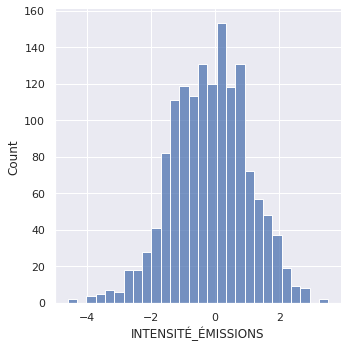

In [12]:
sns.set()
sns.displot(np.log(y))

# <a name="C2">2. Régressions linéaires </a>



## <a name="C20"> 2.0 Baseline - Dummy Regressor </a>

In [13]:
dummy_regr = sklearn.dummy.DummyRegressor(strategy="mean")
dummy_regr.fit(xtrain, ytrain)
y_pred = dummy_regr.predict(xtest)
r2 = metrics.r2_score(ytest, y_pred)
mae = metrics.mean_absolute_error(ytest, y_pred)
rmse = metrics.mean_squared_error(ytest, y_pred, squared = True)

In [14]:
r2, mae, rmse

(-0.00446697966042553, 1.5740084633353288, 10.570918453933903)

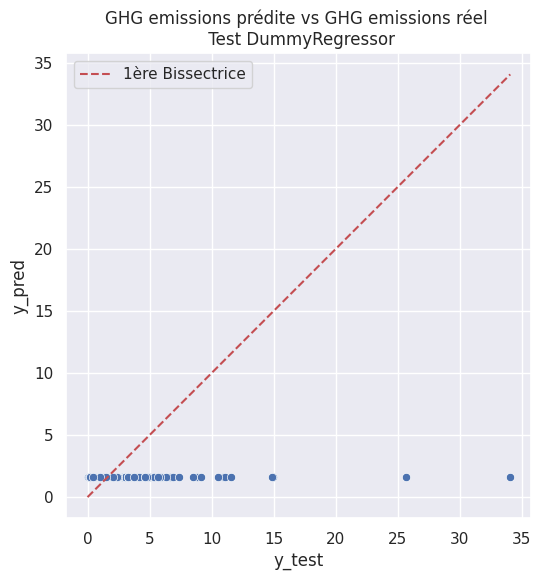

In [15]:
def plot_test(ytest,y_pred,nom_fichier,model,set_,type = None) :
  y_test = ytest
  y_test = np.array(y_test)
  y_pred.shape
  d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
  d_vis['y_test'] = y_test
  d_vis
  if type == 'tree':
    sns.set()
    fig, ax = plt.subplots(figsize =(6,6), dpi = 100)
    sns.lineplot(data = d_vis,x ='y_test', y = 'y_pred', ls = '--')
    sns.scatterplot(data = d_vis,x ='y_test', y = 'y_pred')
    sns.lineplot(x = [0,y_test.max()],y = [0,y_test.max()],ls = '--', color = 'r',  label = '1ère Bissectrice')
  else:
    sns.set()
    fig, ax = plt.subplots(figsize =(6,8), dpi = 100)
    #sns.lineplot(data = d_vis,x ='y_test', y = 'y_pred')
    sns.scatterplot(data = d_vis,x ='y_test', y = 'y_pred')
    sns.lineplot(x = [0,y_test.max()],y = [0,y_test.max()],ls = '--', color = 'r',  label = '1ère Bissectrice')
  ax.set_title('GHG emissions prédite vs GHG emissions réel \n Test '+model)
  plt.axis('square')
  plt.savefig('/content/Fichier_N3/'+nom_fichier+'set'+str(set_), bbox_inches = 'tight', dpi = 150)


  

plot_test(ytest,y_pred,'P4_N3_20_','DummyRegressor',set_)

## <a name="C21"> 2.1 LinearRegression() </a>

In [16]:
score = ['r2','neg_mean_absolute_error', 'neg_root_mean_squared_error']

baseline_cv = Pipeline([('preprocessor', preprocessor),
                        ('model_1', TransformedTargetRegressor(regressor=linear_model.LinearRegression(), 
                                func=np.log, 
                                inverse_func=np.exp))])



In [17]:
#score = ['neg_mean_absolute_error']
cv = 15
val_cr = model_selection.cross_validate(estimator = baseline_cv,
                                        X = xtrain,
                                        y = ytrain,
                                        scoring= score, cv=cv)
print(val_cr['test_r2'])
print(val_cr['test_neg_mean_absolute_error'])
print(val_cr['test_neg_root_mean_squared_error'])


[0.46564073 0.66209963 0.84274857 0.74626864 0.61758621 0.46156071
 0.59560645 0.49506917 0.60539475 0.55180056 0.56908101 0.02951165
 0.39569255 0.46523755 0.6377183 ]
[-0.79779877 -0.62097317 -0.44140259 -0.50178166 -0.69887085 -1.04237766
 -0.64060484 -0.51263123 -0.71159816 -1.01140856 -0.58603182 -0.70403002
 -0.74983394 -0.49824885 -0.52721904]
[-1.81678082 -1.18662272 -0.701645   -0.82587566 -1.23317081 -2.38633509
 -1.30938955 -0.90274304 -1.49652637 -2.44916732 -1.07175227 -1.45850437
 -1.69172741 -1.01156105 -0.96677519]


In [18]:
print('Évaluation du modèle de régression linéaire :\nScore moyen R2 = ', 
      round(np.mean(val_cr['test_r2']), 2), '\nScore moyen neg_MAE = ',
      round(np.mean(val_cr['test_neg_mean_absolute_error']), 2),
      '\nRésultat insuffisant, qui servira de baseline aux autres modèles linéaires. ')

Évaluation du modèle de régression linéaire :
Score moyen R2 =  0.54 
Score moyen neg_MAE =  -0.67 
Résultat insuffisant, qui servira de baseline aux autres modèles linéaires. 


In [19]:
val_cr


{'fit_time': array([0.06398964, 0.06811619, 0.06712556, 0.06897306, 0.06985879,
        0.08549571, 0.07655787, 0.0656116 , 0.07988834, 0.18152547,
        0.12798429, 0.13548422, 0.1282959 , 0.08644199, 0.17165995]),
 'score_time': array([0.01909399, 0.01888227, 0.01960874, 0.01903391, 0.01954412,
        0.0270772 , 0.01845455, 0.01910686, 0.01969624, 0.05017471,
        0.03640652, 0.05526543, 0.02270627, 0.02999115, 0.08207846]),
 'test_r2': array([0.46564073, 0.66209963, 0.84274857, 0.74626864, 0.61758621,
        0.46156071, 0.59560645, 0.49506917, 0.60539475, 0.55180056,
        0.56908101, 0.02951165, 0.39569255, 0.46523755, 0.6377183 ]),
 'test_neg_mean_absolute_error': array([-0.79779877, -0.62097317, -0.44140259, -0.50178166, -0.69887085,
        -1.04237766, -0.64060484, -0.51263123, -0.71159816, -1.01140856,
        -0.58603182, -0.70403002, -0.74983394, -0.49824885, -0.52721904]),
 'test_neg_root_mean_squared_error': array([-1.81678082, -1.18662272, -0.701645  , -0.825875

In [20]:
baseline_cv.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['TYPE', 'FONCTION_1',
                                                   'QUARTIER']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'ANNÉE_CONST_REN',
                                                   'NBRE_IMMEUBLE',
                                                   'NBRE_ÉTAGE',
                                                   'SUPERFICIE_TOTALE',
                                                   'ENERGYSTARScore', 'PARKING',
                                                   'STEAM(kBtu)_part',
                                                   'Electricity(kBtu)_part',
                                                   'NaturalGas(kBtu)_part'])])),
                ('model_1',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [21]:
ct = baseline_cv.named_steps.preprocessor
ct
ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('oneHot', OneHotEncoder(use_cat_names=True),
                                 ['TYPE', 'FONCTION_1', 'QUARTIER']),
                                ('numeric', MinMaxScaler(),
                                 ['LATITUDE', 'LONGITUDE', 'ANNÉE_CONST_REN',
                                  'NBRE_IMMEUBLE', 'NBRE_ÉTAGE',
                                  'SUPERFICIE_TOTALE', 'ENERGYSTARScore',
                                  'PARKING', 'STEAM(kBtu)_part',
                                  'Electricity(kBtu)_part',
                                  'NaturalGas(kBtu)_part'])])

In [22]:
xtrain_trans= ct.fit_transform(xtrain,ytrain)
xtrain_trans

,oneHot__TYPE_NONRESIDENTIAL,oneHot__TYPE_CAMPUS,oneHot__TYPE_SCHOOLS,oneHot__FONCTION_1_RETAIL STORE,oneHot__FONCTION_1_OFFICE,oneHot__FONCTION_1_OTHER,oneHot__FONCTION_1_WAREHOUSE,oneHot__FONCTION_1_HOTEL,oneHot__FONCTION_1_WORSHIP FACILITY,oneHot__FONCTION_1_PUBLIC SERVICES,...,numeric__ANNÉE_CONST_REN,numeric__NBRE_IMMEUBLE,numeric__NBRE_ÉTAGE,numeric__SUPERFICIE_TOTALE,numeric__ENERGYSTARScore,numeric__PARKING,numeric__STEAM(kBtu)_part,numeric__Electricity(kBtu)_part,numeric__NaturalGas(kBtu)_part,remainder__Intercept
757,1,0,0,1,0,0,0,0,0,0,...,0.173913,0.0,0.026316,0.006232,0.353535,0.000000,0.0,0.773857,0.226143,1.0
598,1,0,0,0,1,0,0,0,0,0,...,0.017391,0.0,0.039474,0.004935,0.666667,0.000000,0.0,1.000000,0.000000,1.0
215,1,0,0,1,0,0,0,0,0,0,...,0.121739,0.0,0.052632,0.030718,0.242424,0.000000,0.0,1.000000,0.000000,1.0
135,1,0,0,0,0,1,0,0,0,0,...,0.634783,0.0,0.013158,0.028948,0.939600,0.000000,0.0,0.478450,0.521550,1.0
372,1,0,0,0,0,0,1,0,0,0,...,0.495652,0.0,0.013158,0.017402,0.626263,0.000000,0.0,0.240684,0.759316,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,0,0,0,1,0,0,0,0,0,...,0.504348,0.0,0.026316,0.003963,0.949495,0.000000,0.0,1.000000,0.000000,1.0
905,1,0,0,0,1,0,0,0,0,0,...,0.573913,0.0,0.013158,0.004349,0.929293,0.000000,0.0,0.528202,0.471798,1.0
1096,1,0,0,0,0,0,1,0,0,0,...,0.686957,0.0,0.013158,0.009396,0.509482,0.000000,0.0,0.551135,0.448865,1.0
235,1,0,0,0,1,0,0,0,0,0,...,0.852174,0.0,0.144737,0.165340,0.717172,0.618315,0.0,1.000000,0.000000,1.0


In [23]:
xtrain_trans.describe()

,oneHot__TYPE_NONRESIDENTIAL,oneHot__TYPE_CAMPUS,oneHot__TYPE_SCHOOLS,oneHot__FONCTION_1_RETAIL STORE,oneHot__FONCTION_1_OFFICE,oneHot__FONCTION_1_OTHER,oneHot__FONCTION_1_WAREHOUSE,oneHot__FONCTION_1_HOTEL,oneHot__FONCTION_1_WORSHIP FACILITY,oneHot__FONCTION_1_PUBLIC SERVICES,...,numeric__ANNÉE_CONST_REN,numeric__NBRE_IMMEUBLE,numeric__NBRE_ÉTAGE,numeric__SUPERFICIE_TOTALE,numeric__ENERGYSTARScore,numeric__PARKING,numeric__STEAM(kBtu)_part,numeric__Electricity(kBtu)_part,numeric__NaturalGas(kBtu)_part,remainder__Intercept
count,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,...,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.0
mean,0.977721,0.015424,0.006855,0.085690,0.359897,0.071123,0.192802,0.051414,0.045416,0.006855,...,0.534742,0.010217,0.056544,0.048346,0.620076,0.087442,0.033581,0.707685,0.270373,1.0
std,0.147654,0.123285,0.082547,0.280025,0.480176,0.257140,0.394668,0.220935,0.208303,0.082547,...,0.282502,0.069667,0.086308,0.094132,0.274124,0.185872,0.141036,0.263215,0.264211,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.260870,0.000000,0.013158,0.007512,0.436653,0.000000,0.000000,0.494521,0.000000,1.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.565217,0.000000,0.026316,0.016680,0.666667,0.000000,0.000000,0.724544,0.222649,1.0
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.765217,0.000000,0.052632,0.044080,0.858586,0.000000,0.000000,1.000000,0.486443,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [24]:
xtest_trans= ct.transform(xtest)
xtest_trans

,oneHot__TYPE_NONRESIDENTIAL,oneHot__TYPE_CAMPUS,oneHot__TYPE_SCHOOLS,oneHot__FONCTION_1_RETAIL STORE,oneHot__FONCTION_1_OFFICE,oneHot__FONCTION_1_OTHER,oneHot__FONCTION_1_WAREHOUSE,oneHot__FONCTION_1_HOTEL,oneHot__FONCTION_1_WORSHIP FACILITY,oneHot__FONCTION_1_PUBLIC SERVICES,...,numeric__ANNÉE_CONST_REN,numeric__NBRE_IMMEUBLE,numeric__NBRE_ÉTAGE,numeric__SUPERFICIE_TOTALE,numeric__ENERGYSTARScore,numeric__PARKING,numeric__STEAM(kBtu)_part,numeric__Electricity(kBtu)_part,numeric__NaturalGas(kBtu)_part,remainder__Intercept
1108,1,0,0,0,0,0,1,0,0,0,...,0.217391,0.0,0.026316,0.005967,6.263627e-01,0.000000,0.0,1.000000,0.000000,1.0
111,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.013158,0.017022,-1.405126e-16,0.000000,0.0,0.503116,0.496884,1.0
1273,1,0,0,0,0,0,0,0,1,0,...,0.678261,0.0,0.026316,0.006735,5.959596e-01,0.000000,0.0,0.595487,0.404513,1.0
1147,1,0,0,0,0,0,1,0,0,0,...,0.782609,0.0,0.026316,0.027023,6.355578e-01,0.547157,0.0,0.366887,0.633113,1.0
368,1,0,0,0,0,1,0,0,0,0,...,0.634783,0.0,0.013158,0.044769,9.230711e-01,0.000000,0.0,0.152289,0.847711,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,1,0,0,0,1,0,0,0,0,0,...,0.921739,0.0,0.078947,0.132740,9.696970e-01,0.454290,0.0,0.950527,0.049473,1.0
1400,1,0,0,0,0,0,0,0,0,0,...,0.973913,0.0,0.026316,0.018656,4.027175e-01,0.000000,0.0,0.728644,0.271356,1.0
131,1,0,0,0,0,0,0,0,1,0,...,0.452174,0.0,0.026316,0.020118,4.545455e-01,0.000000,0.0,0.399721,0.600279,1.0
1142,1,0,0,0,1,0,0,0,0,0,...,0.321739,0.0,0.026316,0.012009,9.293127e-01,0.000000,0.0,0.594481,0.405519,1.0


In [25]:
xtest_trans.describe()

,oneHot__TYPE_NONRESIDENTIAL,oneHot__TYPE_CAMPUS,oneHot__TYPE_SCHOOLS,oneHot__FONCTION_1_RETAIL STORE,oneHot__FONCTION_1_OFFICE,oneHot__FONCTION_1_OTHER,oneHot__FONCTION_1_WAREHOUSE,oneHot__FONCTION_1_HOTEL,oneHot__FONCTION_1_WORSHIP FACILITY,oneHot__FONCTION_1_PUBLIC SERVICES,...,numeric__ANNÉE_CONST_REN,numeric__NBRE_IMMEUBLE,numeric__NBRE_ÉTAGE,numeric__SUPERFICIE_TOTALE,numeric__ENERGYSTARScore,numeric__PARKING,numeric__STEAM(kBtu)_part,numeric__Electricity(kBtu)_part,numeric__NaturalGas(kBtu)_part,remainder__Intercept
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,2.920000e+02,292.000000,292.000000,292.000000,292.000000,292.0
mean,0.979452,0.013699,0.006849,0.109589,0.345890,0.065068,0.195205,0.054795,0.044521,0.003425,...,0.531060,0.015279,0.048846,0.041135,6.167626e-01,0.058218,0.038627,0.699057,0.275704,1.0
std,0.142109,0.116436,0.082618,0.312913,0.476474,0.247070,0.397039,0.227969,0.206603,0.058521,...,0.287456,0.154800,0.073918,0.074392,2.762472e-01,0.146448,0.154994,0.260263,0.262619,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003306,-1.405126e-16,0.000000,0.000000,0.090813,0.000000,1.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.243478,0.000000,0.013158,0.007009,4.183919e-01,0.000000,0.000000,0.502018,0.000000,1.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.573913,0.000000,0.026316,0.013819,6.868687e-01,0.000000,0.000000,0.705462,0.239702,1.0
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.756522,0.000000,0.052632,0.037992,8.282828e-01,0.000000,0.000000,1.000000,0.481661,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,0.618421,0.599062,1.000000e+00,0.776779,1.173822,1.000000,0.909187,1.0


In [26]:
import time
start_time = time.time()
y_pred = baseline_cv.predict(xtest)
end_time = time.time()
predict_time = end_time- start_time

score = metrics.r2_score(ytest, y_pred)
mae = metrics.mean_absolute_error(ytest, y_pred)
rmse = metrics.mean_squared_error(ytest, y_pred, squared = False)

score, mae, rmse, predict_time

(0.5215968649031097,
 0.8465888815915967,
 2.2438072014648562,
 0.0515294075012207)

In [27]:
baseline_cv.named_steps.model_1.regressor_.coef_

array([-3.01454124e+13, -3.01454124e+13, -3.01454124e+13, -1.49171205e+13,
       -1.49171205e+13, -1.49171205e+13, -1.49171205e+13, -1.49171205e+13,
       -1.49171205e+13, -1.49171205e+13, -1.49171205e+13, -1.49171205e+13,
       -1.49171205e+13, -1.49171205e+13, -1.49171205e+13, -1.49171205e+13,
       -1.49171205e+13, -1.49171205e+13, -1.49171205e+13, -1.49171205e+13,
       -1.49171205e+13, -1.49171205e+13, -1.49171205e+13,  7.81675888e+11,
        7.81675888e+11,  7.81675888e+11,  7.81675888e+11,  7.81675888e+11,
        7.81675888e+11,  7.81675888e+11,  7.81675888e+11,  7.81675888e+11,
        7.81675888e+11,  7.81675888e+11,  7.81675888e+11,  7.81675888e+11,
        9.91210938e-02,  8.67675781e-01,  2.45849609e-01,  2.48046875e-01,
        5.64575195e-01,  1.30859375e-01, -1.38818359e+00, -5.70312500e-01,
       -2.79949660e+13, -4.28443795e+13, -4.28443795e+13,  0.00000000e+00])

In [28]:
feat_importance = baseline_cv.named_steps.model_1.regressor_.coef_
feat_importance
df_fimp = pd.DataFrame(data = feat_importance, index= xtrain_trans.columns.tolist())
#df_fimp
feat_importance.shape

(48,)

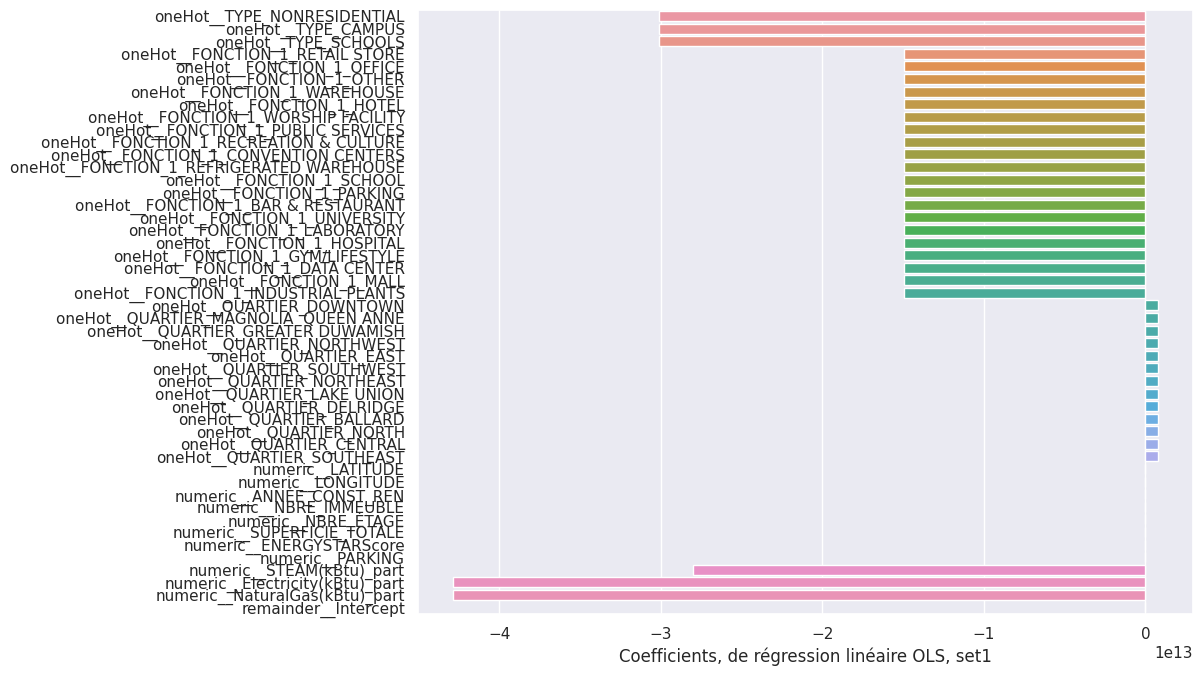

In [29]:
sns.set()
fig,ax = plt.subplots(figsize=(10,8),dpi= 100)
sns.barplot(data = df_fimp.T, orient='h')
ax.set_xlabel('Coefficients, de régression linéaire OLS, set'+str(set_))
plt.savefig('/content/Fichier_N3/'+'P4_N3_21a_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)

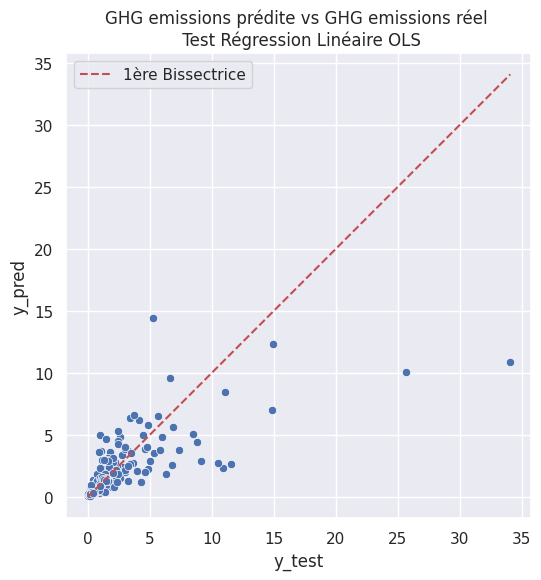

In [30]:
plot_test(ytest,y_pred,'P4_N3_21b_','Régression Linéaire OLS',set_)

In [31]:
df_recap = pd.DataFrame(data = np.nan, columns = ['LinearRegression()'], 
                        index = ['best_param','Temps_training(s)', 'MAE_train_moyen_best_param', 
                                 'R2_train_moyen_best_param', 'RMSE_train_moyen_best_param',
                                'MAE_test_best_param', 'R2_test_best_param', 'RMSE_test_best_param','Temps_prédiction(s)'] )

In [32]:
df_recap.loc['Temps_training(s)'] = round(np.sum(val_cr['fit_time']), 3)
df_recap.loc['MAE_train_moyen_best_param'] = round(np.mean(val_cr['test_neg_mean_absolute_error']), 3)*(-1)
df_recap.loc['R2_train_moyen_best_param'] = round(np.mean(val_cr['test_r2']), 3)
df_recap.loc['RMSE_train_moyen_best_param'] = round(np.mean(val_cr['test_neg_root_mean_squared_error']), 3)*(-1)
df_recap.loc['MAE_test_best_param'] = round(metrics.mean_absolute_error(ytest, y_pred),3)
df_recap.loc['R2_test_best_param'] = round(metrics.r2_score(ytest, y_pred),3)
df_recap.loc['RMSE_test_best_param'] = round(metrics.mean_squared_error(ytest, y_pred, squared = False),3)
df_recap.loc['Temps_prédiction(s)'] = round(predict_time,3)

df_recap

,LinearRegression()
best_param,NaN
Temps_training(s),1.477
MAE_train_moyen_best_param,0.670
R2_train_moyen_best_param,0.543
RMSE_train_moyen_best_param,1.367
MAE_test_best_param,0.847
R2_test_best_param,0.522
RMSE_test_best_param,2.244
Temps_prédiction(s),0.052


## <a href="#C22">2.2 Ridge regression avec GridSearchCV sur $\alpha$ </a>

In [33]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y, 
                                                                 train_size=0.8,
                                                                 random_state = 1)

cv = 15
score = ('neg_mean_absolute_error','r2', 'neg_root_mean_squared_error')
param_grid = {'regressor__alpha':[0.05, 0.1,1,5,7,8,10]}                                                       
# create pipeline
Ridge_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_ridge', model_selection.GridSearchCV(TransformedTargetRegressor(
                                regressor=linear_model.Ridge(), 
                                func=np.log, 
                                inverse_func=np.exp), 
                            param_grid=param_grid,
                            cv=cv,
                            scoring = score,
                            refit='r2',
                            n_jobs = -1))])

In [34]:
#Uniquement en utilsiant GridSearchCV
#Retour des meilleurs scores NMAE et R2
#Stockage du dataframe de resultats du modèle


def model_scores(pip,step,model_nom,cv):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_r2')
    best_r2 = pip.named_steps[step].best_score_
    nmae = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_neg_mean_absolute_error'])*(-1)
    rmse = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_neg_root_mean_squared_error'])*(-1)
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*cv),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(nmae,3), round(best_r2,3), best_params, training_time))
    start_time = time.time()
    y_pred = pip.predict(xtest)
    end_time = time.time()
    predict_time = end_time- start_time
    print("Temps d'execution de l'agorithme : {:.2} s.".format((predict_time)))


    r2_test = metrics.r2_score(ytest, y_pred)
    mae_test = metrics.mean_absolute_error(ytest, y_pred)
    rmse_test = metrics.mean_squared_error(ytest, y_pred, squared = False)

    df_recap[model_nom] = [best_params, training_time, nmae, best_r2,rmse, mae_test,r2_test,rmse_test, predict_time] 
    return df_results, training_time, nmae, best_r2,mae_test,r2_test, best_params , predict_time

In [35]:
Ridge_cv.fit(xtrain, ytrain)

df_res = model_scores(Ridge_cv, 'grid_search_ridge','Ridge()',cv)


Meilleur score MAE : 0.668
Meilleur Score R2 : 0.567
Meilleurs paramètres : {'regressor__alpha': 5}
Temps moyen d'entrainement : 0.26s
Temps d'execution de l'agorithme : 0.14 s.


In [36]:
df_recap

,LinearRegression(),Ridge()
best_param,NaN,{'regressor__alpha': 5}
Temps_training(s),1.477,0.26
MAE_train_moyen_best_param,0.670,0.667786
R2_train_moyen_best_param,0.543,0.566539
RMSE_train_moyen_best_param,1.367,1.352656
MAE_test_best_param,0.847,0.853043
R2_test_best_param,0.522,0.494217
RMSE_test_best_param,2.244,2.307123
Temps_prédiction(s),0.052,0.138945


In [37]:
y_pred = Ridge_cv.predict(xtest)
print("\nSur le jeu de test : {:.3f}".format(metrics.r2_score(ytest, y_pred)))


Sur le jeu de test : 0.494


In [38]:
Ridge_cv.named_steps['grid_search_ridge'].best_estimator_.regressor_.coef_

array([-1.90214945e-01,  1.73180882e-01,  1.70340628e-02,  2.29692754e-01,
       -7.87165814e-02,  9.75373943e-02, -1.06379050e+00, -3.44518472e-02,
       -8.35494941e-01,  1.62906490e-01,  1.19490971e-01, -1.38937439e-01,
        4.73407140e-02, -4.25153498e-01,  1.99327997e-01,  3.42405205e-01,
       -2.29652834e-01,  4.20597838e-01,  5.26859223e-01,  1.07473392e-01,
        7.61116253e-01,  1.26314408e-02, -2.21182032e-01,  4.48244761e-04,
        4.74555222e-02, -1.45481221e-02, -4.08596051e-02,  2.96143645e-03,
        2.59376272e-01, -8.38485229e-02,  6.90160655e-02,  1.49716570e-02,
        3.54633855e-02, -2.06207294e-02, -1.28195516e-01, -1.41620088e-01,
       -5.21880844e-02,  3.74588435e-01,  2.47728485e-01,  1.98493833e-01,
        3.29786800e-01,  1.93270766e-01, -1.29459643e+00, -4.61668344e-01,
        1.22132340e+00, -1.97778072e+00,  1.17975522e+00,  0.00000000e+00])

In [39]:
feat_importance = Ridge_cv.named_steps['grid_search_ridge'].best_estimator_.regressor_.coef_
feat_importance
df_fimp = pd.DataFrame(data = feat_importance, index = xtrain_trans.columns, columns = ['Coefficients'])


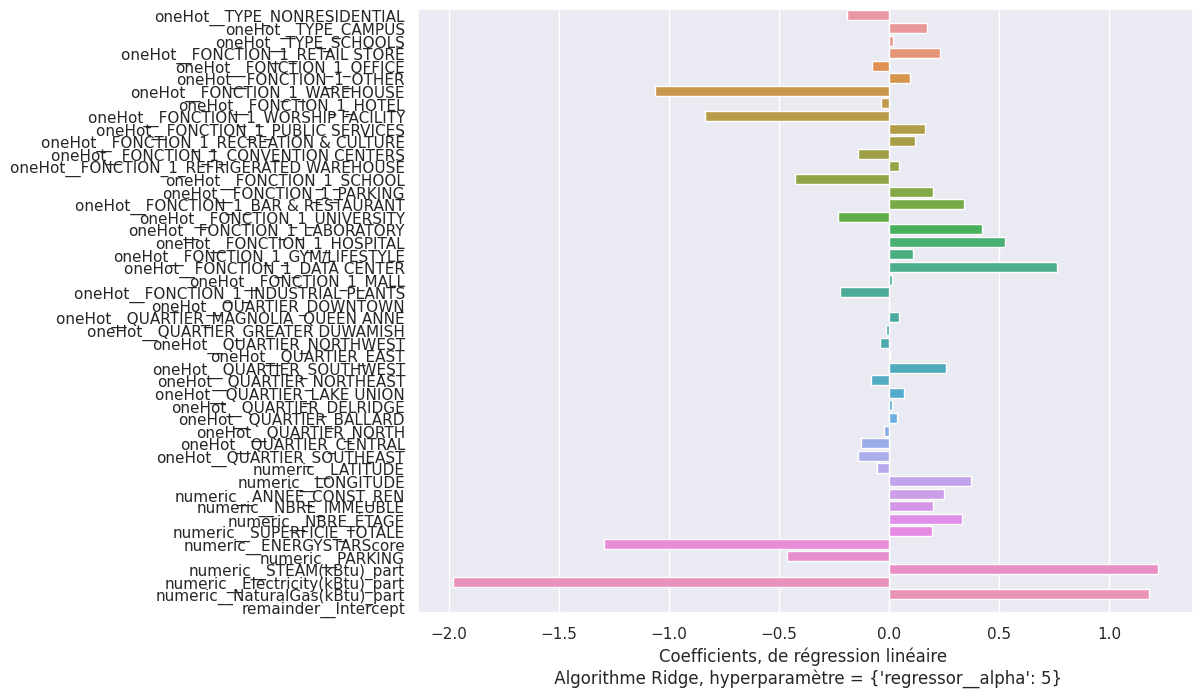

In [40]:
sns.set()
fig,ax = plt.subplots(figsize=(10,8),dpi= 100)
sns.barplot(data = df_fimp.T, orient='h')
ax.set_xlabel('Coefficients, de régression linéaire \n Algorithme Ridge, hyperparamètre = '+str(Ridge_cv.named_steps['grid_search_ridge'].best_params_))
plt.savefig('/content/Fichier_N3/'+'P4_N3_22a_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)

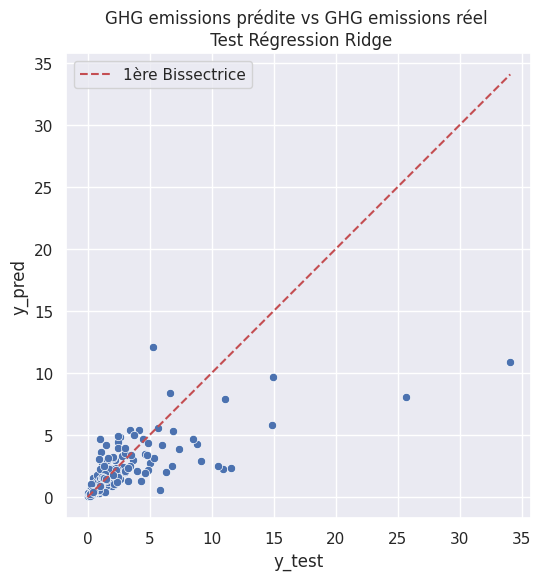

In [41]:
plot_test(ytest,y_pred,'P4_N3_22b_','Régression Ridge',set_)

In [42]:
df_recap

,LinearRegression(),Ridge()
best_param,NaN,{'regressor__alpha': 5}
Temps_training(s),1.477,0.26
MAE_train_moyen_best_param,0.670,0.667786
R2_train_moyen_best_param,0.543,0.566539
RMSE_train_moyen_best_param,1.367,1.352656
MAE_test_best_param,0.847,0.853043
R2_test_best_param,0.522,0.494217
RMSE_test_best_param,2.244,2.307123
Temps_prédiction(s),0.052,0.138945


## <a href="#C23">2.3 Lasso regression avec GridSearchCV sur $\alpha$ </a>

In [43]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y, 
                                                                 train_size=0.8, 
                                                                 random_state = 1)
cv = 15
score = ('neg_mean_absolute_error','r2','neg_root_mean_squared_error')
param_grid = {'regressor__alpha':[1e-2,0.05, 0.1,1,5,10,12, 100,200]}                                                       
# create pipeline
Lasso_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lasso', model_selection.GridSearchCV(TransformedTargetRegressor(
                                regressor=linear_model.Lasso(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_grid,
                            cv=cv,
                            scoring = score, 
                            refit ='r2',
                            n_jobs = -1))])

In [44]:
Lasso_cv.fit(xtrain, ytrain)

df_res = model_scores(Lasso_cv, 'grid_search_lasso','Lasso()',cv)


Meilleur score MAE : 0.725
Meilleur Score R2 : 0.484
Meilleurs paramètres : {'regressor__alpha': 0.01}
Temps moyen d'entrainement : 0.24s
Temps d'execution de l'agorithme : 0.062 s.


In [45]:
df_recap

,LinearRegression(),Ridge(),Lasso()
best_param,NaN,{'regressor__alpha': 5},{'regressor__alpha': 0.01}
Temps_training(s),1.477,0.26,0.24
MAE_train_moyen_best_param,0.670,0.667786,0.725286
R2_train_moyen_best_param,0.543,0.566539,0.484327
RMSE_train_moyen_best_param,1.367,1.352656,1.477383
MAE_test_best_param,0.847,0.853043,0.918652
R2_test_best_param,0.522,0.494217,0.35503
RMSE_test_best_param,2.244,2.307123,2.605304
Temps_prédiction(s),0.052,0.138945,0.062435


In [46]:
Lasso_cv.named_steps['grid_search_lasso'].best_estimator_.regressor_.coef_

array([-0.        ,  0.        ,  0.        ,  0.10515426, -0.09463587,
        0.        , -1.03946221, -0.        , -0.71804099,  0.        ,
        0.        , -0.        ,  0.        , -0.15618446,  0.        ,
        0.        , -0.        ,  0.        ,  0.10095898,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.09022541,  0.        ,
        0.        ,  0.        , -1.24765049, -0.0096187 ,  0.33689353,
       -3.09567481,  0.        ,  0.        ])

In [47]:
feat_importance = Lasso_cv.named_steps['grid_search_lasso'].best_estimator_.regressor_.coef_
feat_importance
df_fimp = pd.DataFrame(data = feat_importance, index = xtrain_trans.columns, columns = ['Coefficient'])


In [48]:
df_fimp[df_fimp['Coefficient']!= 0.]

,Coefficient
oneHot__FONCTION_1_RETAIL STORE,0.105154
oneHot__FONCTION_1_OFFICE,-0.094636
oneHot__FONCTION_1_WAREHOUSE,-1.039462
oneHot__FONCTION_1_WORSHIP FACILITY,-0.718041
oneHot__FONCTION_1_SCHOOL,-0.156184
oneHot__FONCTION_1_HOSPITAL,0.100959
numeric__ANNÉE_CONST_REN,0.090225
numeric__ENERGYSTARScore,-1.247650
numeric__PARKING,-0.009619
numeric__STEAM(kBtu)_part,0.336894


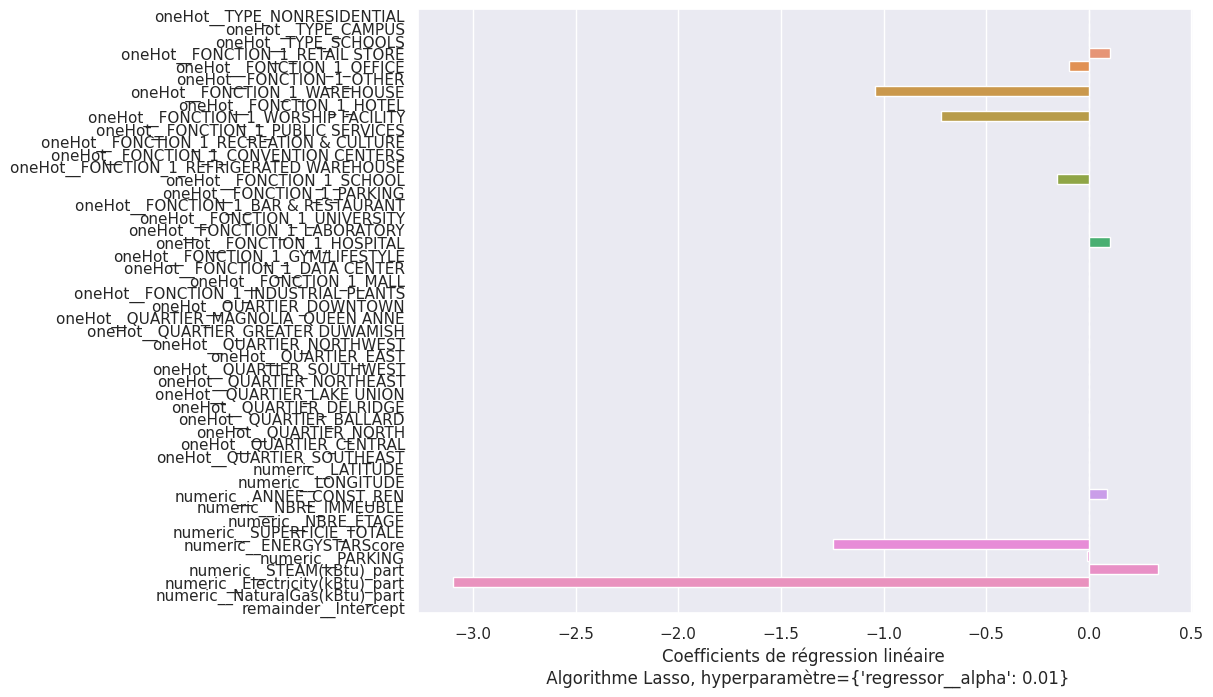

In [49]:
fig,ax = plt.subplots(figsize=(10,8),dpi= 100)
sns.barplot(data = df_fimp.reset_index(), x = 'Coefficient', y = 'index')
ax.set_xlabel('Coefficients de régression linéaire \n Algorithme Lasso, hyperparamètre='+str(Lasso_cv.named_steps['grid_search_lasso'].best_params_))
ax.set_ylabel('')
plt.savefig('/content/Fichier_N3/'+'P4_N3_23a_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [50]:
y_pred = Lasso_cv.predict(xtest)

In [51]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

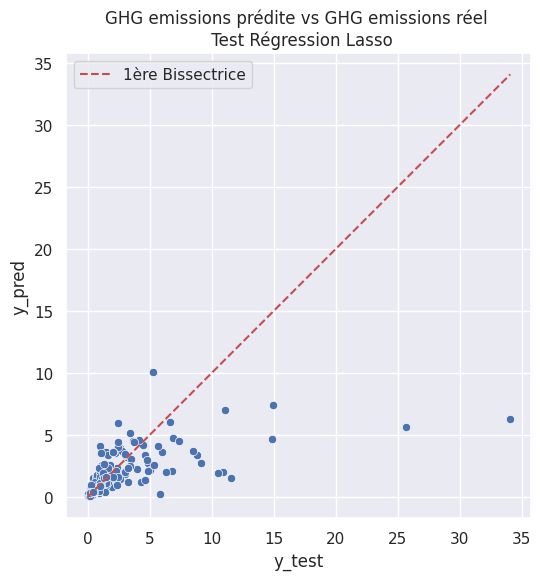

In [52]:
plot_test(ytest,y_pred,'P4_N3_23b_','Régression Lasso',set_)

## <a name="C24"> 2.4 ElasticNET  </a>

In [53]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                 train_size=0.8,
                                                                 random_state = 1
                                                             )
cv = 15
score = ('neg_mean_absolute_error','r2','neg_root_mean_squared_error')
param_eNet = {'regressor__max_iter': [10, 100, 1000],
              'regressor__alpha': np.logspace(-4, 0, num=5),
              'regressor__l1_ratio': np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', model_selection.GridSearchCV(TransformedTargetRegressor(
                                regressor=linear_model.ElasticNet(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_eNet,
                            cv=cv,
                            scoring= score,
                            refit='r2',
                            n_jobs = -1))])

In [54]:
eNet_grid_cv.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['TYPE', 'FONCTION_1',
                                                   'QUARTIER']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'ANNÉE_CONST_REN',
                                                   'NBRE_IMMEUBLE',
                                                   'NBRE_ÉTAGE',
                                                   'SUPERFICIE_TOTALE',
                                                   'ENERGYSTARScore', 'PARKING',
                                                   'STEAM(kBtu)_part',
                                                   'Electricity(kBtu)_p...
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=ElasticNet()),
                              n_jobs=-1,
                              param_grid={'regressor__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                                          'regressor__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'regressor__max_iter': [10, 100,
                                                                  1000]},
                              refit='r2',
                              scoring=('neg_mean_absolute_error', 'r2',
                                       'neg_root_mean_squared_error')))])

In [55]:
df_res = model_scores(eNet_grid_cv,'grid_search_enet','ENET()',cv)

Meilleur score MAE : 0.668
Meilleur Score R2 : 0.556
Meilleurs paramètres : {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.2, 'regressor__max_iter': 1000}
Temps moyen d'entrainement : 0.35s
Temps d'execution de l'agorithme : 0.044 s.


In [56]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET()
best_param,NaN,{'regressor__alpha': 5},{'regressor__alpha': 0.01},"{'regressor__alpha': 0.001, 'regressor__l1_rat..."
Temps_training(s),1.477,0.26,0.24,0.35
MAE_train_moyen_best_param,0.670,0.667786,0.725286,0.667512
R2_train_moyen_best_param,0.543,0.566539,0.484327,0.555877
RMSE_train_moyen_best_param,1.367,1.352656,1.477383,1.356351
MAE_test_best_param,0.847,0.853043,0.918652,0.846841
R2_test_best_param,0.522,0.494217,0.35503,0.538594
RMSE_test_best_param,2.244,2.307123,2.605304,2.203587
Temps_prédiction(s),0.052,0.138945,0.062435,0.044059


In [57]:
y_pred = eNet_grid_cv.predict(xtest)

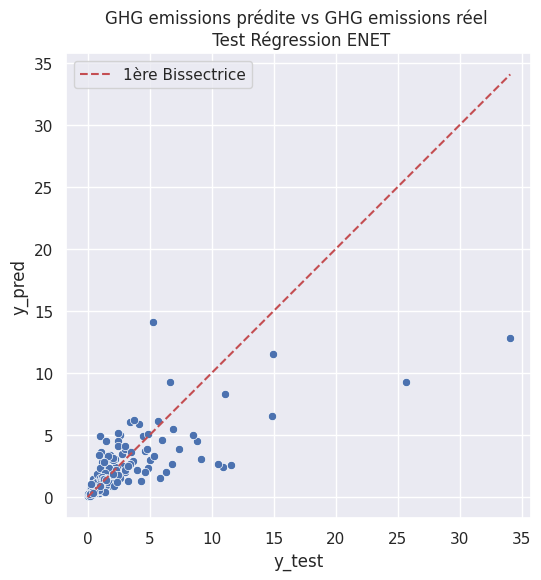

In [58]:
plot_test(ytest,y_pred,'P4_N3_24b_','Régression ENET',set_)

# <a name="C3"> 3. Régression non linéaires  </a>


## <a name="C31"> 3.1 LinearSVR / SVR </a>

In [59]:
from sklearn import svm


In [60]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                 train_size=0.8,
                                                                 random_state = 1
                                                             )

In [61]:
# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'regressor__C': C_range}
              #'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = ('neg_mean_absolute_error','r2','neg_root_mean_squared_error')

cv = 15
SVR = Pipeline(steps=[('preprocessor', preprocessor),
                      ('grid_svr',model_selection.GridSearchCV(TransformedTargetRegressor(
                                regressor=svm.LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp), 
                                                               param_grid =param_grid, 
                                                               cv=cv, 
                                                               scoring=score,
                                                               refit = 'r2',
                                                               n_jobs = -1))])
                      
                      
                    

In [62]:
# faire tourner la recherche sur grille
SVR.fit(xtrain, ytrain)

df_res = model_scores(SVR,'grid_svr','linearSVR()',cv)

Meilleur score MAE : 0.681
Meilleur Score R2 : 0.544
Meilleurs paramètres : {'regressor__C': 0.1}
Temps moyen d'entrainement : 1.12s
Temps d'execution de l'agorithme : 0.054 s.


In [63]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR()
best_param,NaN,{'regressor__alpha': 5},{'regressor__alpha': 0.01},"{'regressor__alpha': 0.001, 'regressor__l1_rat...",{'regressor__C': 0.1}
Temps_training(s),1.477,0.26,0.24,0.35,1.12
MAE_train_moyen_best_param,0.670,0.667786,0.725286,0.667512,0.68139
R2_train_moyen_best_param,0.543,0.566539,0.484327,0.555877,0.543785
RMSE_train_moyen_best_param,1.367,1.352656,1.477383,1.356351,1.389256
MAE_test_best_param,0.847,0.853043,0.918652,0.846841,0.871806
R2_test_best_param,0.522,0.494217,0.35503,0.538594,0.428608
RMSE_test_best_param,2.244,2.307123,2.605304,2.203587,2.452198
Temps_prédiction(s),0.052,0.138945,0.062435,0.044059,0.054278


In [64]:
y_pred = SVR.predict(xtest)

In [65]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

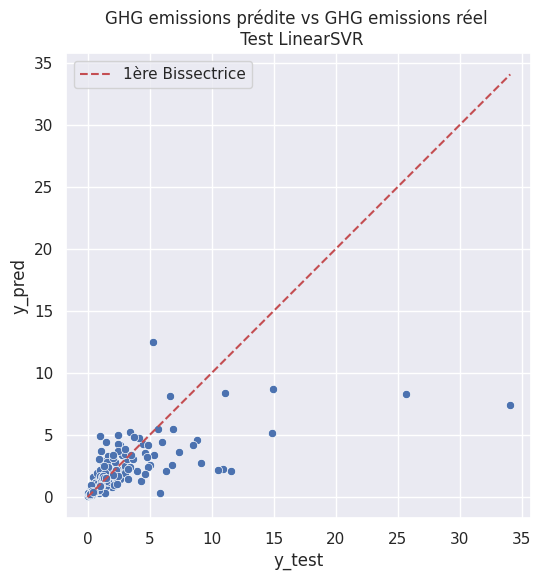

In [66]:
plot_test(ytest,y_pred,'P4_N3_31b_','LinearSVR',set_)


## <a name="C32"> 3.2 DecisionTreeRegressor </a>

In [67]:
from sklearn.tree import DecisionTreeRegressor

In [68]:
X = df.drop(columns =['INTENSITÉ_ÉMISSIONS','Intercept' ])
y = df['INTENSITÉ_ÉMISSIONS']

In [69]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                train_size=0.8,
                                                               random_state = 1
                                                            )

if (set_ == 1) | (set_==3):
  #set1 et set3
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer, cat_features)], remainder='passthrough')
else:
  #set2 
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer0, cat_features),
    ('target', target_transformer1, cat_features_fonction)], remainder='passthrough')

In [70]:
score = ('neg_mean_absolute_error','r2','neg_root_mean_squared_error')

param_Tree = {'criterion': ['squared_error', 'absolute_error'],
              'max_depth': [2,3, 4,5, 6],
             }
cv = 15
Tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('grid_tree',
                       model_selection.GridSearchCV(estimator = DecisionTreeRegressor(random_state=1), 
                                                               param_grid =param_Tree, 
                                                               cv=cv, 
                                                               scoring=score,
                                                               refit = 'r2',
                                                               n_jobs = -1))])


In [71]:
Tree.fit(xtrain, ytrain)

df_res = model_scores(Tree,'grid_tree','DecisionTree()',cv)

Meilleur score MAE : 0.912
Meilleur Score R2 : 0.255
Meilleurs paramètres : {'criterion': 'absolute_error', 'max_depth': 2}
Temps moyen d'entrainement : 1.23s
Temps d'execution de l'agorithme : 0.014 s.


In [72]:
y_pred =Tree.predict(xtest)

In [73]:
score = metrics.r2_score(ytest, y_pred)
mae = metrics.mean_absolute_error(ytest, y_pred)
score, mae

(0.172304873288039, 1.1007534246575341)

In [74]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

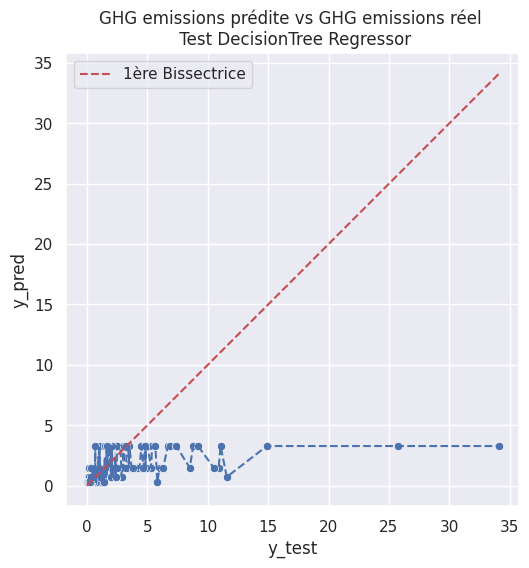

In [75]:
plot_test(ytest,y_pred,'P4_N3_41b_','DecisionTree Regressor', set_,type = 'tree')


In [76]:
ct = Tree.named_steps['preprocessor']
ct.set_output(transform="pandas")
xtest_trans_tree = ct.transform(xtest)

### <a name="C321"> 3.2.bonus Feature Importance <a>

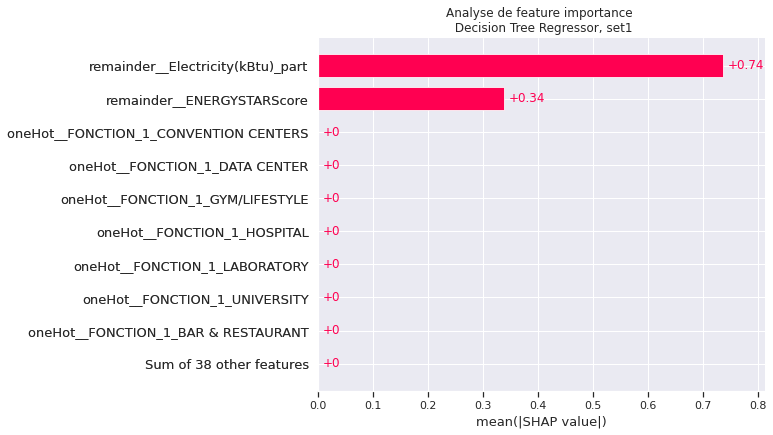

In [77]:
def feat_shap(xtest,model,nomfichier,nommodel,set_):
  # DF, based on which importance is checked
  X_importance = xtest

  # Explain model predictions using shap library:
  explainer = shap.TreeExplainer(model)
  shap_values = explainer(X_importance)

  # Plot summary_plot as barplot:
  shap.plots.bar(shap_values, max_display=10, show = False)
  #shap.summary_plot(shap_values, X_importance, plot_type='bar')
  plt.title('Analyse de feature importance \n '+nommodel+', set'+str(set_))
  plt.savefig('/content/Fichier_N3/'+nomfichier+str(set_)+'.png', bbox_inches = 'tight')
  plt.show()

model = Tree.named_steps['grid_tree'].best_estimator_
feat_shap(xtest_trans_tree,model,'P4_N3_32a_set_','Decision Tree Regressor',set_)


In [78]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR(),DecisionTree()
best_param,NaN,{'regressor__alpha': 5},{'regressor__alpha': 0.01},"{'regressor__alpha': 0.001, 'regressor__l1_rat...",{'regressor__C': 0.1},"{'criterion': 'absolute_error', 'max_depth': 2}"
Temps_training(s),1.477,0.26,0.24,0.35,1.12,1.23
MAE_train_moyen_best_param,0.670,0.667786,0.725286,0.667512,0.68139,0.912409
R2_train_moyen_best_param,0.543,0.566539,0.484327,0.555877,0.543785,0.254917
RMSE_train_moyen_best_param,1.367,1.352656,1.477383,1.356351,1.389256,1.779459
MAE_test_best_param,0.847,0.853043,0.918652,0.846841,0.871806,1.100753
R2_test_best_param,0.522,0.494217,0.35503,0.538594,0.428608,0.172305
RMSE_test_best_param,2.244,2.307123,2.605304,2.203587,2.452198,2.95137
Temps_prédiction(s),0.052,0.138945,0.062435,0.044059,0.054278,0.013524


## <a name="C33"> 3.3 RandomForestRegressor </a>

In [79]:
from sklearn.ensemble import RandomForestRegressor

param_rfr = {'n_estimators' : [55, 100, 125, 150],
             'max_depth': [25, 26, 27, 28,30],
             #'criterion' :['squared_error', 'absolute_error']
            }
cv = 15
rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', model_selection.GridSearchCV(RandomForestRegressor(bootstrap = True, 
                                                                           criterion = 'squared_error', 
                                                                           random_state=1),
                            param_grid=param_rfr,
                            cv=cv,
                            scoring=('r2','neg_mean_absolute_error','neg_root_mean_squared_error'),
                            refit='r2',
                            return_train_score = True,
                            n_jobs = -1))])

In [80]:
rfr_grid_cv.fit(xtrain, ytrain)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(rfr_grid_cv.named_steps['grid_search_rfr'].best_params_)


df_res = model_scores(rfr_grid_cv,'grid_search_rfr','RandomForest()',cv)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 25, 'n_estimators': 125}
Meilleur score MAE : 0.741
Meilleur Score R2 : 0.498
Meilleurs paramètres : {'max_depth': 25, 'n_estimators': 125}
Temps moyen d'entrainement : 28.98s
Temps d'execution de l'agorithme : 0.046 s.


In [81]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR(),DecisionTree(),RandomForest()
best_param,NaN,{'regressor__alpha': 5},{'regressor__alpha': 0.01},"{'regressor__alpha': 0.001, 'regressor__l1_rat...",{'regressor__C': 0.1},"{'criterion': 'absolute_error', 'max_depth': 2}","{'max_depth': 25, 'n_estimators': 125}"
Temps_training(s),1.477,0.26,0.24,0.35,1.12,1.23,28.98
MAE_train_moyen_best_param,0.670,0.667786,0.725286,0.667512,0.68139,0.912409,0.741365
R2_train_moyen_best_param,0.543,0.566539,0.484327,0.555877,0.543785,0.254917,0.498288
RMSE_train_moyen_best_param,1.367,1.352656,1.477383,1.356351,1.389256,1.779459,1.396599
MAE_test_best_param,0.847,0.853043,0.918652,0.846841,0.871806,1.100753,0.911229
R2_test_best_param,0.522,0.494217,0.35503,0.538594,0.428608,0.172305,0.424188
RMSE_test_best_param,2.244,2.307123,2.605304,2.203587,2.452198,2.95137,2.461665
Temps_prédiction(s),0.052,0.138945,0.062435,0.044059,0.054278,0.013524,0.045573


In [82]:
y_pred = rfr_grid_cv.predict(xtest)



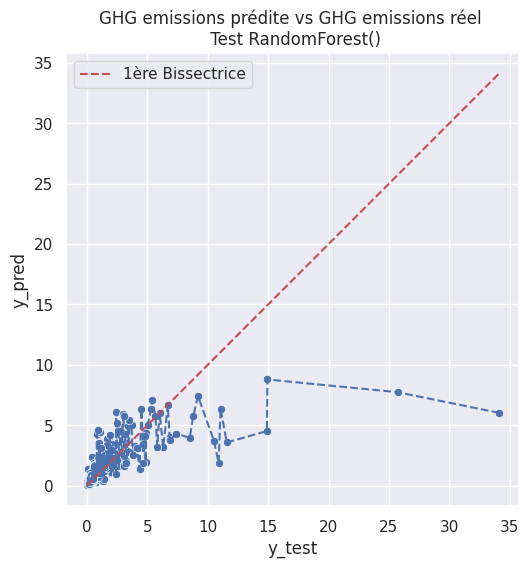

In [83]:
plot_test(ytest,y_pred,'P4_N3_33b_','RandomForest()', set_,type = 'tree')

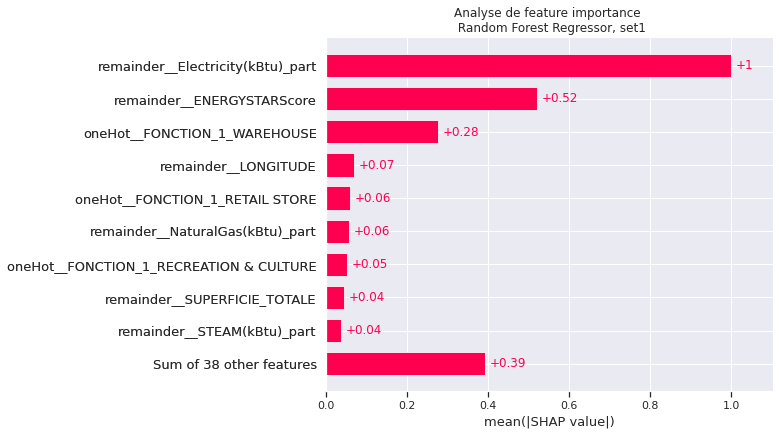

In [84]:
model = rfr_grid_cv.named_steps['grid_search_rfr'].best_estimator_
feat_shap(xtest_trans_tree,model,'P4_N3_33a_','Random Forest Regressor',set_)


## <a name="C34"> 3.4 XGBOOST  </a>

In [85]:
import xgboost as xgb

param_xgb = {'max_depth': [ 10, 12, 15, 20],
            'learning_rate': [0.01, 0.1, 0.3],
             'subsample': [0.2, 0.5, 0.8],
             'n_estimators':[35,40,50]

             }
cv = 15
xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgb', model_selection.GridSearchCV(estimator=xgb.XGBRegressor(random_state = 30), 
                                                     param_grid=param_xgb,
                                                     cv=cv,
                                                     scoring=('r2','neg_mean_absolute_error','neg_root_mean_squared_error'),
                                                     return_train_score=True,
                                                     refit='r2',
                                                     n_jobs = -1))])

In [86]:
# Optimiser ce modèle de régression sur le jeu d'entrainement
xgb_grid_cv.fit(xtrain, ytrain)


df_res = model_scores(xgb_grid_cv,'grid_search_xgb','XGBOOST()',cv)

Meilleur score MAE : 0.704
Meilleur Score R2 : 0.553
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 40, 'subsample': 0.5}
Temps moyen d'entrainement : 10.49s
Temps d'execution de l'agorithme : 0.028 s.


In [87]:
y_pred = xgb_grid_cv.predict(xtest)

In [88]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

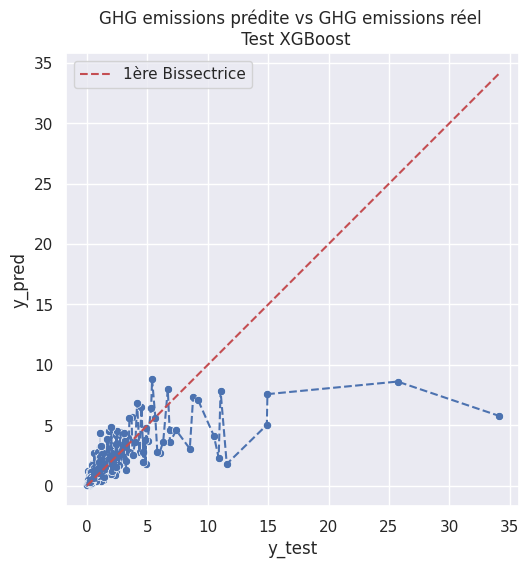

In [89]:
plot_test(ytest,y_pred,'P4_N3_34b_','XGBoost',set_, type = 'tree')


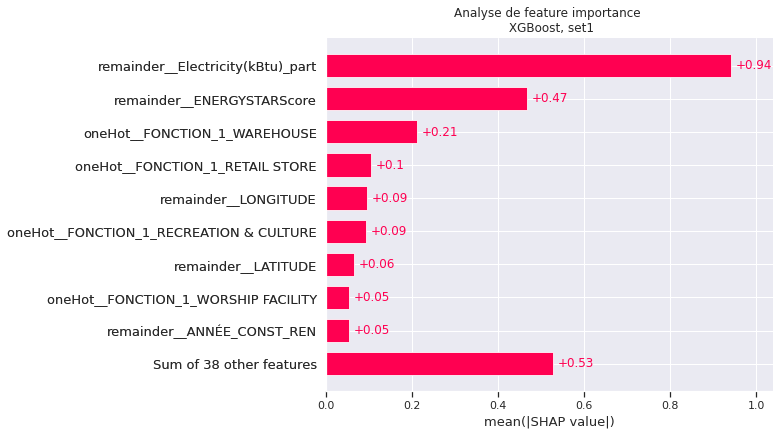

In [90]:
model = xgb_grid_cv.named_steps['grid_search_xgb'].best_estimator_
feat_shap(xtest_trans_tree,model,'P4_N3_34a_','XGBoost',set_)


# <a name="C4"> 4. Conclusion </a>

Pour la prédiction de l'intensité de consommation énergétique, l'algorithme XGBOOST est le plus performant (résultat pour le Set 1)  


In [91]:
df_recap = df_recap.T.reset_index()

In [92]:
df_recap = df_recap.rename(columns = {'index':'Modèle'})
df_recap

,Modèle,best_param,Temps_training(s),MAE_train_moyen_best_param,R2_train_moyen_best_param,RMSE_train_moyen_best_param,MAE_test_best_param,R2_test_best_param,RMSE_test_best_param,Temps_prédiction(s)
0,LinearRegression(),NaN,1.477,0.67,0.543,1.367,0.847,0.522,2.244,0.052
1,Ridge(),{'regressor__alpha': 5},0.26,0.667786,0.566539,1.352656,0.853043,0.494217,2.307123,0.138945
2,Lasso(),{'regressor__alpha': 0.01},0.24,0.725286,0.484327,1.477383,0.918652,0.35503,2.605304,0.062435
3,ENET(),"{'regressor__alpha': 0.001, 'regressor__l1_rat...",0.35,0.667512,0.555877,1.356351,0.846841,0.538594,2.203587,0.044059
4,linearSVR(),{'regressor__C': 0.1},1.12,0.68139,0.543785,1.389256,0.871806,0.428608,2.452198,0.054278
5,DecisionTree(),"{'criterion': 'absolute_error', 'max_depth': 2}",1.23,0.912409,0.254917,1.779459,1.100753,0.172305,2.95137,0.013524
6,RandomForest(),"{'max_depth': 25, 'n_estimators': 125}",28.98,0.741365,0.498288,1.396599,0.911229,0.424188,2.461665,0.045573
7,XGBOOST(),"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",10.49,0.70404,0.552571,1.317739,0.889383,0.43346,2.441765,0.028149


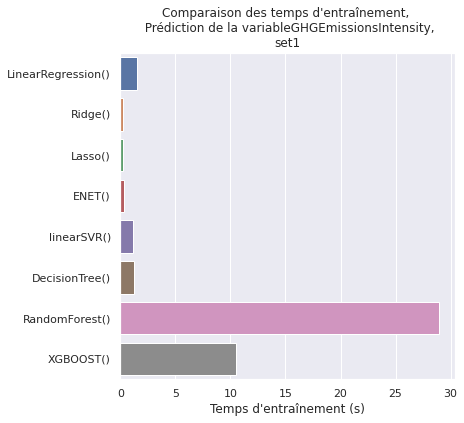

In [93]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'Temps_training(s)', orient = 'h')
ax.set_xlabel('Temps d\'entraînement (s)')
ax.set_ylabel('')
ax.set_title('Comparaison des temps d\'entraînement, \n Prédiction de la variable'+tar_name+',\nset'+str(set_))
plt.savefig('/content/Fichier_N3/'+'P4_N3_41_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


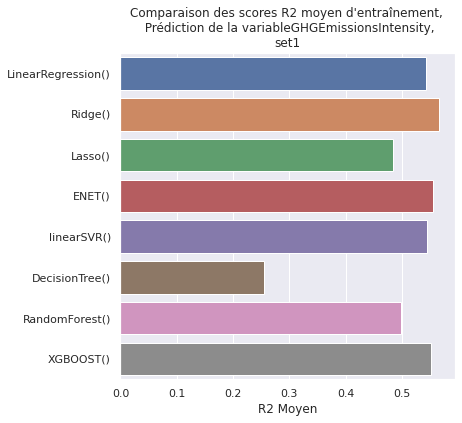

In [94]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'R2_train_moyen_best_param', orient = 'h')
ax.set_xlabel('R2 Moyen')
ax.set_ylabel('')
ax.set_title('Comparaison des scores R2 moyen d\'entraînement, \n Prédiction de la variable'+tar_name+',\nset'+str(set_))
plt.savefig('/content/Fichier_N3/'+'P4_N3_42_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


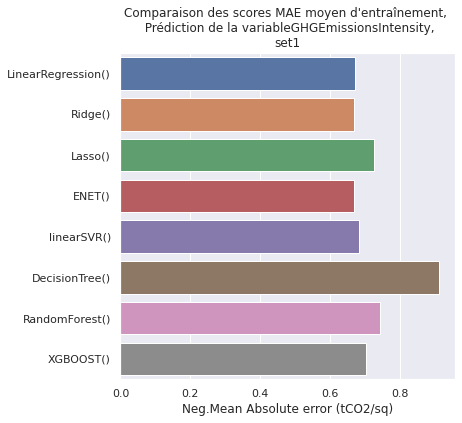

In [95]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'MAE_train_moyen_best_param', orient = 'h')
ax.set_xlabel('Neg.Mean Absolute error (tCO2/sq)')
ax.set_ylabel('')
ax.set_title('Comparaison des scores MAE moyen d\'entraînement, \n Prédiction de la variable'+tar_name+',\nset'+str(set_))
plt.savefig('/content/Fichier_N3/'+'P4_N3_43_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


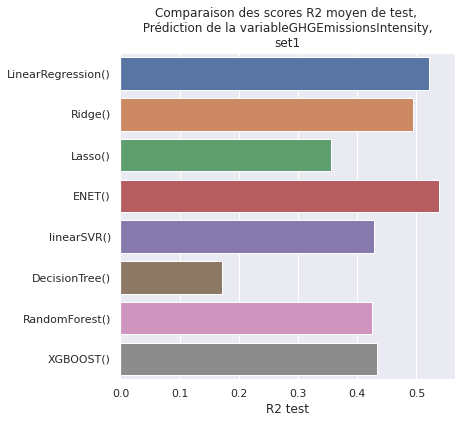

In [96]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'R2_test_best_param', orient = 'h')
ax.set_xlabel('R2 test')
ax.set_ylabel('')
ax.set_title('Comparaison des scores R2 moyen de test, \n Prédiction de la variable'+tar_name+', \nset'+str(set_))
plt.savefig('/content/Fichier_N3/'+'P4_N3_44_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [97]:
df_test_pred = pd.concat([xtest,ytest],axis=1)
df_test_pred 

,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part,INTENSITÉ_ÉMISSIONS
1108,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000,0.06
111,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884,4.51
1273,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513,0.54
1147,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113,0.63
368,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473,0.23
1400,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356,11.57
131,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279,1.49
1142,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519,1.01


In [98]:
y_pred_best = xgb_grid_cv.predict(xtest)

In [99]:
df_test_pred['y_pred'] = y_pred_best
df_test_pred

,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part,INTENSITÉ_ÉMISSIONS,y_pred
1108,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000,0.06,0.120038
111,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884,4.51,6.491455
1273,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513,0.54,1.277816
1147,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113,0.63,1.353779
368,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711,0.97,1.528538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473,0.23,0.278188
1400,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356,11.57,1.794127
131,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279,1.49,1.525844
1142,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519,1.01,1.029710


In [100]:
df_test_pred['abs_error'] = np.abs(df_test_pred['INTENSITÉ_ÉMISSIONS']- df_test_pred['y_pred'])
df_test_pred

,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part,INTENSITÉ_ÉMISSIONS,y_pred,abs_error
1108,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000,0.06,0.120038,0.060038
111,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884,4.51,6.491455,1.981455
1273,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513,0.54,1.277816,0.737816
1147,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113,0.63,1.353779,0.723779
368,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711,0.97,1.528538,0.558538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473,0.23,0.278188,0.048188
1400,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356,11.57,1.794127,9.775873
131,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279,1.49,1.525844,0.035844
1142,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519,1.01,1.029710,0.019710


In [101]:
np.mean(df_test_pred['abs_error']) #vérification OK

0.889382660856394

In [102]:
df_test_pred.groupby(by='FONCTION_1').mean()['abs_error']

FONCTION_1
BAR & RESTAURANT          3.057048
DATA CENTER               3.009439
HOSPITAL                  9.775873
HOTEL                     0.427886
INDUSTRIAL PLANTS         2.809594
LABORATORY                6.024562
MALL                      0.123489
OFFICE                    0.546015
OTHER                     0.929637
PARKING                   0.265058
PUBLIC SERVICES           0.071408
RECREATION & CULTURE      1.890915
REFRIGERATED WAREHOUSE    0.694234
RETAIL STORE              1.277707
SCHOOL                    0.938508
UNIVERSITY                1.275289
WAREHOUSE                 0.393899
WORSHIP FACILITY          0.868219
Name: abs_error, dtype: float64

In [103]:
ERR = df_test_pred.groupby(by='FONCTION_1').mean()['abs_error']
ERR = ERR.reset_index()


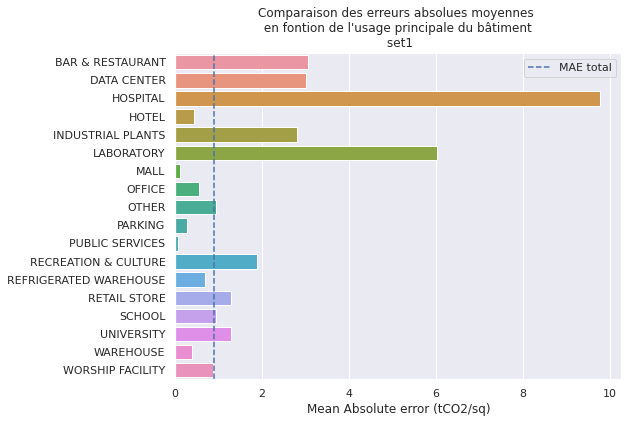

In [104]:
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(data = ERR, y = 'FONCTION_1', x = 'abs_error',
            orient = 'h')
vline = g.axvline(np.mean(df_test_pred['abs_error']), ls = '--', label = 'MAE total')
ax.set_ylabel('')
ax.set_xlabel('Mean Absolute error (tCO2/sq)')
ax.set_title('Comparaison des erreurs absolues moyennes \n en fontion de l\'usage principale du bâtiment \n set'+str(set_))
plt.legend()
plt.savefig('/content/Fichier_N3/'+'P4_N3_45_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)

In [105]:
ERR = df_test_pred.groupby(by='QUARTIER').mean()['abs_error']
ERR = ERR.reset_index()
ERR 

,QUARTIER,abs_error
0,BALLARD,0.803514
1,CENTRAL,0.831931
2,DELRIDGE,0.922136
3,DOWNTOWN,0.827860
4,EAST,1.340198
5,GREATER DUWAMISH,0.774975
6,LAKE UNION,0.925284
7,MAGNOLIA QUEEN ANNE,0.510008
8,NORTH,0.517636
9,NORTHEAST,0.726089


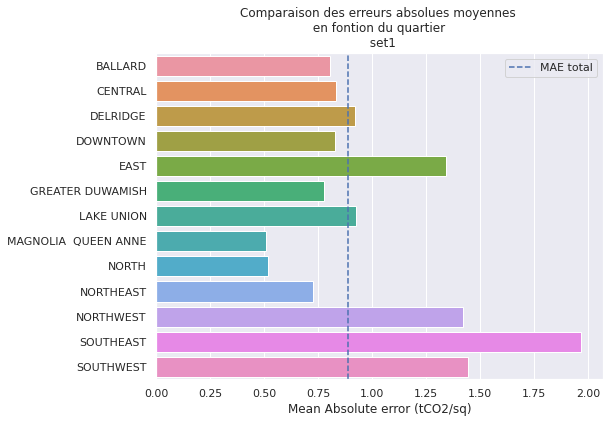

In [106]:
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(data = ERR, y = 'QUARTIER', x = 'abs_error',
            orient = 'h')
vline = g.axvline(np.mean(df_test_pred['abs_error']), ls = '--', label = 'MAE total')

ax.set_ylabel('')
ax.set_xlabel('Mean Absolute error (tCO2/sq)')
ax.set_title('Comparaison des erreurs absolues moyennes \n en fontion du quartier \n  set'+str(set_))
plt.legend()
plt.savefig('/content/Fichier_N3/'+'P4_N3_46_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [107]:
ERR = df_test_pred.groupby(by='TYPE').mean()['abs_error']
ERR = ERR.reset_index()
ERR 

,TYPE,abs_error
0,CAMPUS,7.855631
1,NONRESIDENTIAL,0.795929
2,SCHOOLS,0.320706


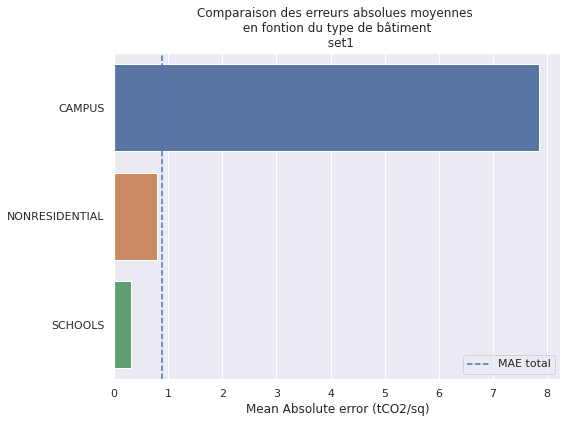

In [108]:
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(data = ERR, y = 'TYPE', x = 'abs_error',
            orient = 'h')
vline = g.axvline(np.mean(df_test_pred['abs_error']), ls = '--', label = 'MAE total')

ax.set_ylabel('')
ax.set_xlabel('Mean Absolute error (tCO2/sq)')
ax.set_title('Comparaison des erreurs absolues moyennes \n en fontion du type de bâtiment \n  set'+str(set_))
plt.legend()
plt.savefig('/content/Fichier_N3/'+'P4_N3_47_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [109]:
from google.colab import files
df_recap.to_csv('Fichier_N3/'+'set'+str(set_)+'_res_GHG.csv') 

In [110]:
!zip -r Fichier_N3.zip Fichier_N3

  adding: Fichier_N3/ (stored 0%)
  adding: Fichier_N3/P4_N3_20_set1.png (deflated 10%)
  adding: Fichier_N3/P4_N3_44_set1.png (deflated 18%)
  adding: Fichier_N3/P4_N3_41b_set1.png (deflated 9%)
  adding: Fichier_N3/P4_N3_22a_set1.png (deflated 18%)
  adding: Fichier_N3/P4_N3_21b_set1.png (deflated 10%)
  adding: Fichier_N3/P4_N3_22b_set1.png (deflated 9%)
  adding: Fichier_N3/P4_N3_45_set1.png (deflated 15%)
  adding: Fichier_N3/P4_N3_21a_set1.png (deflated 19%)
  adding: Fichier_N3/P4_N3_23a_set1.png (deflated 19%)
  adding: Fichier_N3/P4_N3_41_set1.png (deflated 18%)
  adding: Fichier_N3/P4_N3_31b_set1.png (deflated 9%)
  adding: Fichier_N3/P4_N3_43_set1.png (deflated 18%)
  adding: Fichier_N3/P4_N3_33a_1.png (deflated 14%)
  adding: Fichier_N3/P4_N3_46_set1.png (deflated 16%)
  adding: Fichier_N3/P4_N3_23b_set1.png (deflated 10%)
  adding: Fichier_N3/P4_N3_24b_set1.png (deflated 10%)
  adding: Fichier_N3/P4_N3_32a_set_1.png (deflated 17%)
  adding: Fichier_N3/P4_N3_42_set1.png (de

In [111]:
files.download('Fichier_N3.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>